### Building Chatbot With Multiple Tools Using Langgraph

#### Aim
Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [3]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [4]:
arxiv.invoke("Attention iss all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [6]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [7]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [11]:
"""
STEP 3: Environment Setup
Load API credentials securely from environment variables.
"""

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get Google API key with error handling
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
if not GOOGLE_API_KEY:
    raise ValueError("GOOGLE_API_KEY not found in environment variables")
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
if not TAVILY_API_KEY:
    raise ValueError("TAVILY_API_KEY not found in environment variables")

print("✓ API keys loaded successfully")

✓ API keys loaded successfully


In [9]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI

# Initialize Google embeddings model for vector representation
embedding_model = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001", 
    google_api_key=GOOGLE_API_KEY
)


# Initialize Google's Gemini model for response generation
llm = ChatGoogleGenerativeAI(
    google_api_key=GOOGLE_API_KEY,
    model="gemini-2.0-flash",    # Latest fast Gemini model for quick reranking
    temperature=0,               # Deterministic output for consistency in ranking
    max_tokens=None,            # Use model default token limit
    timeout=None,               # No timeout limit for ranking requests
    max_retries=2,              # Retry failed requests twice
)

print("✓ Gemini model initialized for reranking")

/home/bjit/Desktop/Storage01/SelfDevelopment/Rag_Course/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Gemini model initialized for reranking


In [13]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults(api_key=TAVILY_API_KEY, n_results=5)

In [14]:
### Combine all the tools in the list

tools=[arxiv,wiki,tavily]

In [15]:

llm_with_tools=llm.bind_tools(tools)

In [16]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "recent AI News"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--7e7c0476-e6cd-4f2e-beb8-0be229395bbc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent AI News'}, 'id': '4a3229b1-fda0-4905-8253-3ea914d1b53f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 163, 'output_tokens': 12, 'total_tokens': 175, 'input_token_details': {'cache_read': 0}})

In [17]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI News'},
  'id': '5ed7f820-78a3-453e-b7b5-681120977c0f',
  'type': 'tool_call'}]

In [18]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

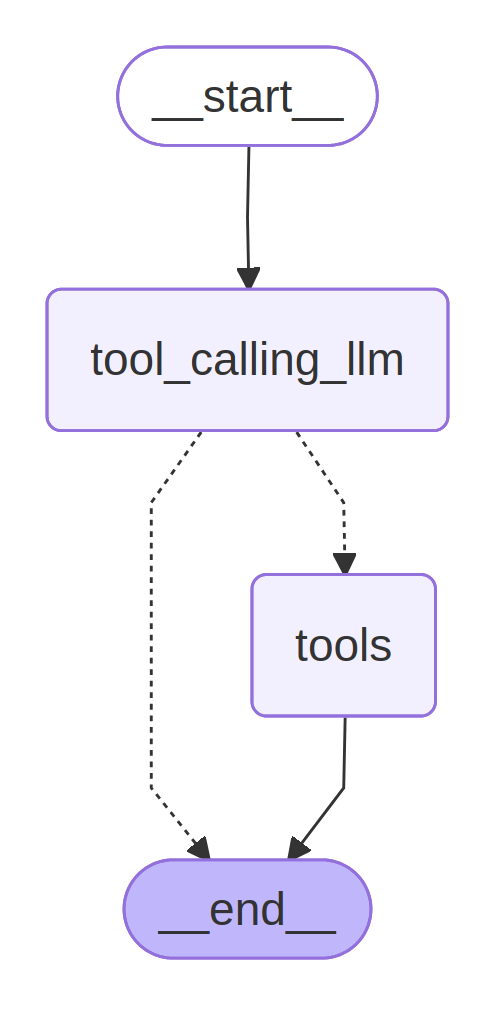

In [20]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables.graph import MermaidDrawMethod 

from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

import nest_asyncio
nest_asyncio.apply()

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))


In [21]:
messages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================

Please provide the context or question related to the arXiv ID 1706.03762. I need to know what you want to find out about this paper. For example, are you interested in the title, abstract, authors, or a specific topic related to the paper?


In [22]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for MArch 3rd 2025")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for MArch 3rd 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (87f0b2dc-a61a-470d-b3e1-c17e3bf6d671)
 Call ID: 87f0b2dc-a61a-470d-b3e1-c17e3bf6d671
  Args:
    query: AI news March 3rd 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Weekly AI News: 3 March 2025 - AIforBusiness.net - YouTube", "url": "https://www.youtube.com/watch?v=kw21NJ7YmZM", "content": "This week’s AI update explores some of the most impactful developments shaping technology and society. OpenAI has unveiled GPT-4.5, a cutting-edge model with enhanced intuition and emotional intelligence. While its capabilities push AI closer to human-like perception, its high computational demands raise concerns about accessibility, particularly for small

In [23]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (15df62fa-f6fa-4d47-87d6-5cf5aa2c9e29)
 Call ID: 15df62fa-f6fa-4d47-87d6-5cf5aa2c9e29
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi


In [35]:
messages['messages'][-1]

ToolMessage(content='Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi', name='wikipedia', id='db0789ab-3e5d-4d32-a8c7-b46a8ccdf89c', tool_call_id='15df62fa-f6fa-4d47-87d6-5cf5aa2c9e29')

In [36]:
messages['messages'][-1].content

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'